In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# load the csv file
df = pd.read_csv('crypto_data.csv')

## Data cleaning

In [3]:
# filter for coins those are currently traded
trading_df = df[df['IsTrading'] == True]

# drop 'IsTrading' col, because it's useless now
trading_df = trading_df.drop('IsTrading', axis=1)
trading_df

,Unnamed: 0,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,PoW,NaN,611000
4,808,808,SHA-256,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...
1243,SERO,Super Zero,Ethash,PoW,NaN,1000000000
1244,UOS,UOS,SHA-256,DPoI,NaN,1000000000
1245,BDX,Beldex,CryptoNight,PoW,9.802226e+08,1400222610
1246,ZEN,Horizen,Equihash,PoW,7.296538e+06,21000000


In [4]:
# remove rows with null values
trading_df.dropna(axis=0)

,Unnamed: 0,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
4,808,808,SHA-256,PoW/PoS,0.000000e+00,0
5,1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
...,...,...,...,...,...,...
1238,ZEPH,ZEPHYR,SHA-256,DPoS,2.000000e+09,2000000000
1242,GAP,Gapcoin,Scrypt,PoW/PoS,1.493105e+07,250000000
1245,BDX,Beldex,CryptoNight,PoW,9.802226e+08,1400222610
1246,ZEN,Horizen,Equihash,PoW,7.296538e+06,21000000


In [5]:
# filter for coins that are being mined: total coins mined > 0
trading_df = trading_df[trading_df['TotalCoinsMined'] > 0]

In [7]:
# drop CoinName col, since those name has no numeric value
trading_df= trading_df.drop(['CoinName', 'Unnamed: 0'], axis=1)

In [8]:
trading_df

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0
...,...,...,...,...
1238,SHA-256,DPoS,2.000000e+09,2000000000
1242,Scrypt,PoW/PoS,1.493105e+07,250000000
1245,CryptoNight,PoW,9.802226e+08,1400222610
1246,Equihash,PoW,7.296538e+06,21000000


In [9]:
# convert 'Algorithm' and 'ProofType' into dummies
trading_df_dummies = pd.get_dummies(trading_df, columns=['Algorithm', 'ProofType'])

In [11]:
# standardize the data
crypto_scaled = StandardScaler().fit_transform(trading_df_dummies)

In [14]:
crypto_scaled.shape

(532, 98)

## Models

In [19]:
pca = PCA(n_components=.99)
crypto_pca_99 = pca.fit_transform(crypto_scaled)

In [20]:
crypto_pca.shape

(532, 86)

### to preserve 99% explained variance, PCA reduce the number of features from 98 to 86

In [21]:
pca_90 = PCA(n_components=.90)
crypto_pca_90 = pca_90.fit_transform(crypto_scaled)

In [22]:
crypto_pca_90.shape

(532, 74)

### to preserve 99% explained variance, PCA reduce the number of features to 74

In [32]:
from sklearn.manifold import TSNE

In [38]:
# Initialize t-SNE model
tsne = TSNE(learning_rate=100)

In [39]:
tsne_features = tsne.fit_transform(crypto_pca_90)
tsne_features.shape

/Users/kaipham/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(532, 2)

In [40]:
type(tsne_features)

numpy.ndarray

In [41]:
tsne_df = pd.DataFrame()
tsne_df['x'] = tsne_features[:,0]
tsne_df['y'] = tsne_features[:,1]

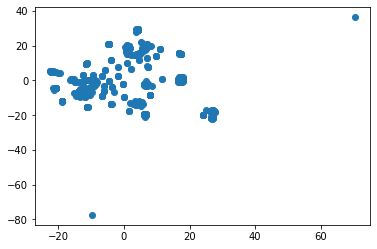

In [42]:
# Visualize the clusters with color
plt.scatter(tsne_df['x'], tsne_df['y'])
plt.show()

### there is no clear cluster pattern on the graph
with so many features reduced, a lot of information is now hidden

## K Means

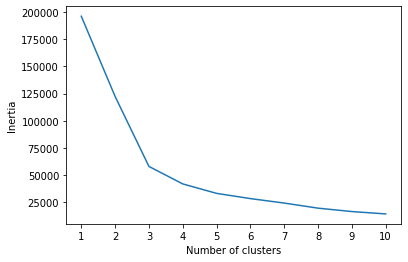

In [43]:
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(tsne_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

pick k = 3
## analysis with K = 3

In [47]:
def km_cluster(k, df):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(df)

    # Predict clusters
    predictions = model.predict(df)

    # Create return DataFrame with predicted clusters
    df["class"] = model.labels_
    return df

In [48]:
km_cluster(3, tsne_df)

,x,y,class
0,6.418512,20.337448,1
1,0.501444,16.663511,1
2,3.720300,28.059704,1
3,27.577366,-17.738831,2
4,-18.793934,-12.076477,0
...,...,...,...
527,24.932894,-17.113285,2
528,3.603976,15.026436,1
529,-22.094227,4.885703,0
530,-20.850595,-4.510291,0


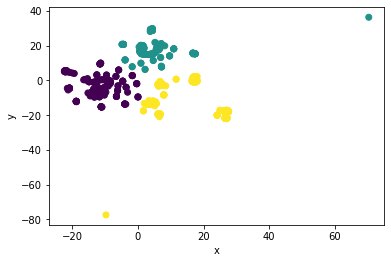

In [49]:
plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['class'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [50]:
# with 4 clusters
km_cluster(4, tsne_df)

,x,y,class
0,6.418512,20.337448,1
1,0.501444,16.663511,1
2,3.720300,28.059704,1
3,27.577366,-17.738831,2
4,-18.793934,-12.076477,0
...,...,...,...
527,24.932894,-17.113285,2
528,3.603976,15.026436,1
529,-22.094227,4.885703,0
530,-20.850595,-4.510291,0


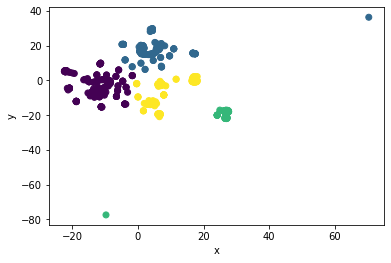

In [51]:
plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['class'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Recommendation based on observations:
1.  with the data from crypto currency, we can divide them into 4 different groups
2. However, I strongly would not recommend this clustering model. Here are the reasons:
        the majority of the clusters are too closed to each other
        there is no clear seperation or some sort of "boundaries" to unravel the patterns.
        the t-SNE model has reduce the dimension a lots, it's posible those ommited features contain more info?!
I would like to try to find clusters after PCA (skip t-SNE)